# New improved machine learn model code (test)

In [6]:
# import all needed libs
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# read datasets into datadframe
train_set = pd.read_pickle('../train_val_test_data/train_set.pkl')
validation_set = pd.read_pickle('../train_val_test_data/validation_set.pkl')
test_set = pd.read_pickle('../train_val_test_data/test_set.pkl')

# Remove all NaN rows / TODO: investigate and improve this 
train_set = train_set.dropna(subset=['Umsatz'])
validation_set = validation_set.dropna(subset=['Umsatz'])

# check if NaN left
#print(test_set.isna().sum())


#train_set.head()

train_set.columns

Index(['Datum', 'Warengruppe', 'Umsatz', 'Bewoelkung', 'Temperatur',
       'Windgeschwindigkeit', 'Wettercode', 'Jahr_Monat', 'monthly_mean_temp',
       'monthly_mean_temp_diff', 'sunny', 'Wind_Kategorie', 'rainday',
       'snowday', 'KielerWoche', 'Salesindex', 'HolyCode', 'SchholCode',
       'BinHoly', 'BinSchhol', 'BinElec', 'DayOfWeek', 'weekend'],
      dtype='object')

## Normalization of Numerical features

In [36]:
def prepare_features(data_df):
    # Define categorical features
    categorical_features = ['Warengruppe', 'Wind_Kategorie']

    # Inspect data types and unique values for categorical columns
    #print(data_df[categorical_features].dtypes)
    #print("Unique Values:\n",data_df[categorical_features].apply(lambda x: x.unique()))

    # Ensure categorical columns are treated as categories
    for col in categorical_features:
        data_df[col] = data_df[col].astype('category')

    # Encode categorical variables using pd.get_dummies
    features = pd.get_dummies(data_df[categorical_features], drop_first=True, dtype=int)

    # Include any numeric columns that are not categorical
    features['rainday'] = data_df['rainday']
    features['Salesindex'] = data_df['Salesindex']
    features['monthly_mean_temp_diff'] = data_df['monthly_mean_temp_diff']
    features['sunny'] = data_df['sunny']
    features['KielerWoche'] = data_df['KielerWoche']
    features['BinHoly'] = data_df['BinHoly']
    features['BinSchhol'] = data_df['BinSchhol']
    features['weekend'] = data_df['weekend']
    
    # Normalize numerical features
    # numerical_features = ['rainday', 'Salesindex', 'monthly_mean_temp_diff', 'sunny', 'KielerWoche', 'BinHoly', 'BinSchhol', 'weekend', 'day_of_week', 'month', 'quarter']
    # scaler = StandardScaler()
    # features[numerical_features] = scaler.fit_transform(features[numerical_features])

    # Construct the prepared data set including the dependent variable ('label')
    # prepared_data = pd.concat([data_df[['Umsatz']], features], axis=1).dropna()

    return features

# We need separated features and labels

# create the lable first
training_features =prepare_features(train_set)
validation_features = prepare_features(validation_set)
test_features = prepare_features(test_set)


# Add Umsatz to training and validation lables
training_labels = train_set[['Umsatz']]
validation_labels = validation_set[['Umsatz']]
# test_data contains no lable for Umsatz 

#test_labels = test_data[['Umsatz']]

# Display the shape of the prepared data set
#print(training_features.shape)
# Display the first few rows of the prepared data set
#print(training_features.head(5))

#print(training_labels.shape)
#print(training_labels.head(5))

#print(train_set.head(5))

# Convert DataFrames to numpy arrays
training_features_array = training_features.to_numpy()
training_labels_array = training_labels.to_numpy().flatten()  # Flatten in case labels are a DataFrame with one column


# check for infinite numbers
#print(np.isfinite(training_features).all())
#print(np.isfinite(training_labels).all())


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import KFold

#cross validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for train_index, val_index in kf.split(training_features):
    X_train, X_val = training_features.iloc[train_index], training_features.iloc[val_index]
    y_train, y_val = training_labels.iloc[train_index], training_labels.iloc[val_index]
    

#Increasing the number of units and adding dropout layers to help prevent overfitting by randomly deactivating neurons during training
model = Sequential([
    InputLayer(shape=(training_features.shape[1], )),
    BatchNormalization(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1)
])

model.summary()

model.compile(loss="mse", optimizer=Adam(learning_rate=0.001))

# Early stopping and Learning Rate Reduction to improve training
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

# improved code by specifying the batch size
history = model.fit(X_train, y_train, epochs=250, batch_size=32,
                        validation_data=(X_val, y_val),
                        callbacks=[early_stopping, reduce_lr])

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_8           │ (None, 15)             │            60 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,197 (12.49 KB)

 Trainable params: 3,167 (12.37 KB)

 Non-trainable params: 30 (120.00 B)

Epoch 1/250
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 62049.5664 - val_loss: 44061.8438 - learning_rate: 0.0010
Epoch 2/250
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 17446.7969 - val_loss: 7264.3564 - learning_rate: 0.0010
Epoch 3/250
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 10041.3438 - val_loss: 5804.0723 - learning_rate: 0.0010
Epoch 4/250
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9275.2969 - val_loss: 5362.2778 - learning_rate: 0.0010
Epoch 5/250
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11443.2959 - val_loss: 5195.7456 - learning_rate: 0.0010
Epoch 6/250
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9991.9072 - val_loss: 5069.9087 - learning_rate: 0.0010
Epoch 7/250
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9693.0830 - val_loss: 5070.9048 - learning_rate: 0.0010
Epoch 8/250
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8721.7822 - val_loss: 4994.3618 - learning_rate: 0.0010
Epoch 9/250
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss

In [29]:
model.save("python_model_test.keras")

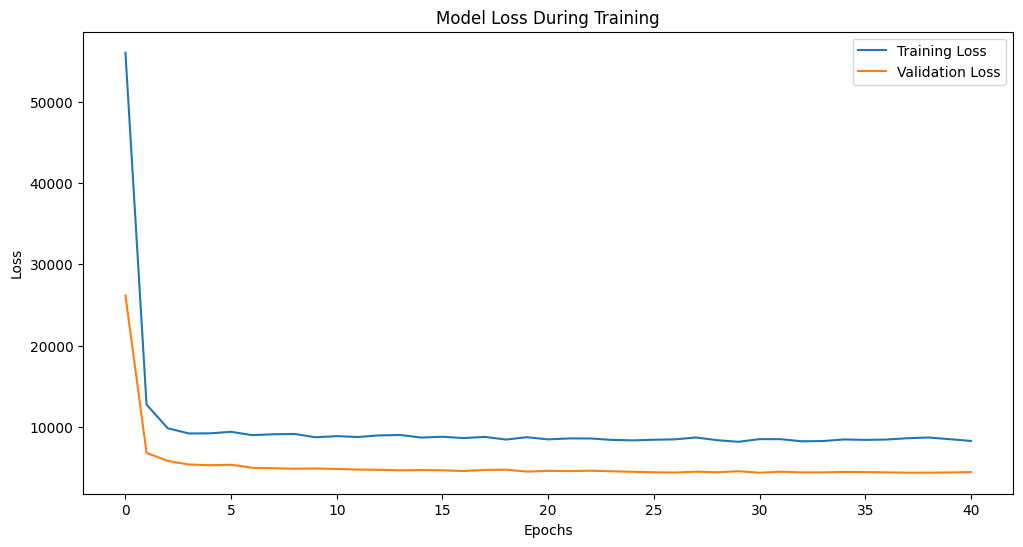

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [31]:
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_mask = y_true != 0
    return np.mean(np.abs((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask])) * 100

training_predictions = model.predict(training_features)
validation_predictions = model.predict(validation_features)
print(f"MAPE on the Training Data: {mape(training_labels, training_predictions):.2f}%")
print(f"MAPE on the Validation Data: {mape(validation_labels, validation_predictions):.2f}%")

235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
MAPE on the Training Data: 27.89%
MAPE on the Validation Data: 27.48%


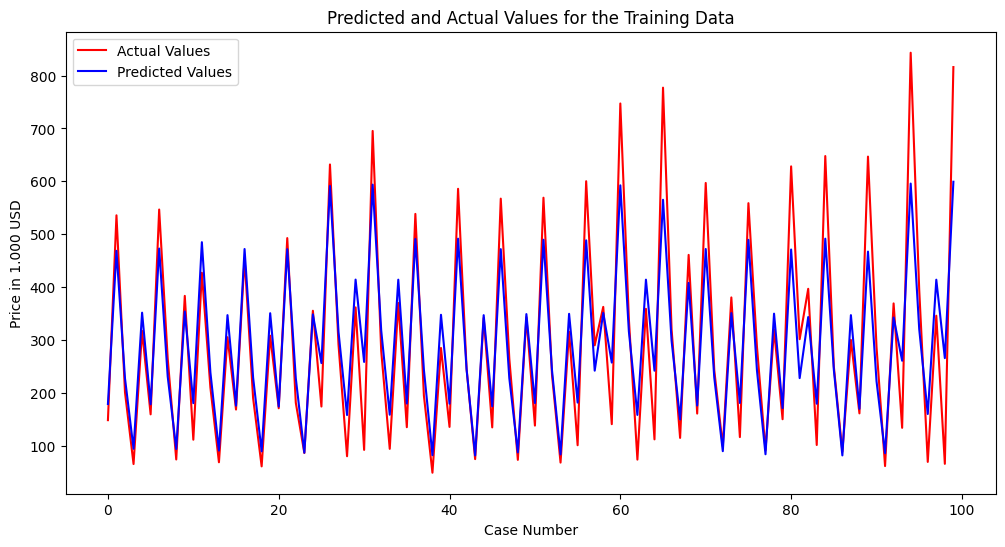

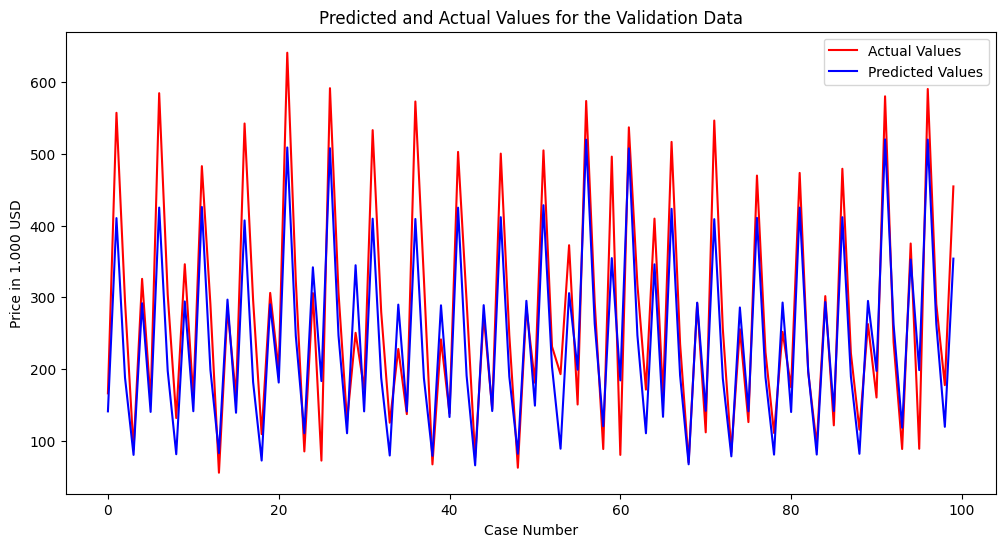

In [32]:
def plot_predictions(data, title):
    plt.figure(figsize=(12, 6))
    plt.plot(data['actual'], label='Actual Values', color='red')
    plt.plot(data['prediction'], label='Predicted Values', color='blue')
    plt.title(title)
    plt.xlabel('Case Number')
    plt.ylabel('Price in 1.000 USD')
    plt.legend()
    plt.show()

# Ensure that training_predictions, validation_predictions, training_labels, and validation_labels are numpy arrays
training_predictions = np.array(training_predictions).flatten()
validation_predictions = np.array(validation_predictions).flatten()
training_labels = np.array(training_labels).flatten()
validation_labels = np.array(validation_labels).flatten()

# Create DataFrames with 1-dimensional arrays
data_train = pd.DataFrame({'prediction': training_predictions, 'actual': training_labels})
data_validation = pd.DataFrame({'prediction': validation_predictions, 'actual': validation_labels})

# Plot predictions
plot_predictions(data_train.head(100), 'Predicted and Actual Values for the Training Data')
plot_predictions(data_validation.head(100), 'Predicted and Actual Values for the Validation Data')

In [33]:
# calculate predictions for testdata
test_predictions = model.predict(test_features)

# flatten and convert from numpy into pandas dataframe
test_predictions = np.array(test_predictions).flatten()
test_predictions_df = pd.DataFrame({'Umsatz': test_predictions})

test_predictions_df.head()

test_set.head()

# merge the IDs from test date togther with Umsatz predictions
# TODO: check if we have any problems because of no common date index on both dataframes
submission_set = pd.concat([test_set['id'], test_predictions_df['Umsatz']], axis=1)

# Check if the count of dataset is correct for kaggle upload
if submission_set.shape[0] == 1830:
    print("OK : DataFrame has exact 1830 Entries!")
else:
    print(f"ERROR Dataframe has wrong number of {submission_set.shape[0]} Entries!")

# store the submission data
submission_set.to_csv('../prediction_data/submission_test.csv', index=False)

58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 917us/step
OK : DataFrame has exact 1830 Entries!
